# 你的第一个神经网络

在此项目中，你将构建你的第一个神经网络，并用该网络预测每日自行车租客人数。我们提供了一些代码，但是需要你来实现神经网络（大部分内容）。提交此项目后，欢迎进一步探索该数据和模型。

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 加载和准备数据

构建神经网络的关键一步是正确地准备数据。不同尺度级别的变量使网络难以高效地掌握正确的权重。我们在下方已经提供了加载和准备数据的代码。你很快将进一步学习这些代码！

In [3]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [4]:
rides.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

## 数据简介

此数据集包含的是从 2011 年 1 月 1 日到 2012 年 12 月 31 日期间每天每小时的骑车人数。骑车用户分成临时用户和注册用户，cnt 列是骑车用户数汇总列。你可以在上方看到前几行数据。

下图展示的是数据集中前 10 天左右的骑车人数（某些天不一定是 24 个条目，所以不是精确的 10 天）。你可以在这里看到每小时租金。这些数据很复杂！周末的骑行人数少些，工作日上下班期间是骑行高峰期。我们还可以从上方的数据中看到温度、湿度和风速信息，所有这些信息都会影响骑行人数。你需要用你的模型展示所有这些数据。

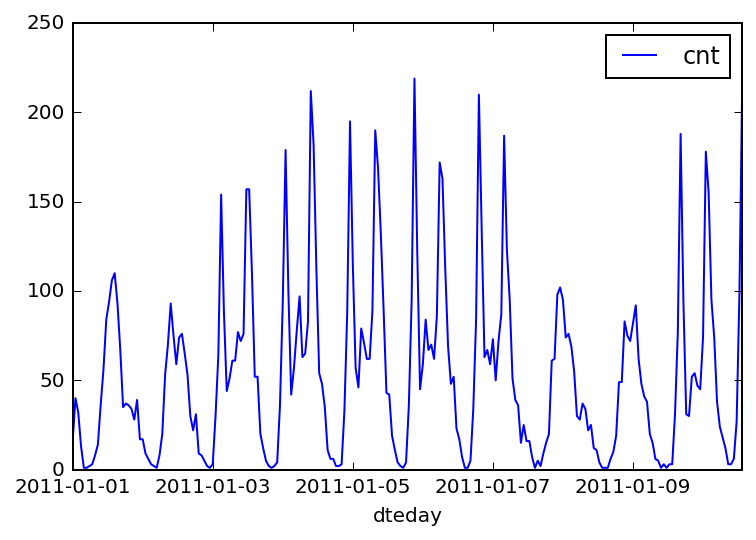

In [5]:
rides[:24*10].plot(x='dteday', y='cnt')

### 虚拟变量（哑变量）

下面是一些分类变量，例如季节、天气、月份。要在我们的模型中包含这些数据，我们需要创建二进制虚拟变量。用 Pandas 库中的 `get_dummies()` 就可以轻松实现。

In [6]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

yr  holiday  temp   hum  windspeed  casual  registered  cnt  season_1  \
0   0        0  0.24  0.81        0.0       3          13   16         1   
1   0        0  0.22  0.80        0.0       8          32   40         1   
2   0        0  0.22  0.80        0.0       5          27   32         1   
3   0        0  0.24  0.75        0.0       3          10   13         1   
4   0        0  0.24  0.75        0.0       0           1    1         1   

   season_2    ...      hr_21  hr_22  hr_23  weekday_0  weekday_1  weekday_2  \
0         0    ...          0      0      0          0          0          0   
1         0    ...          0      0      0          0          0          0   
2         0    ...          0      0      0          0          0          0   
3         0    ...          0      0      0          0          0          0   
4         0    ...          0      0      0          0          0          0   

   weekday_3  weekday_4  weekday_5  weekday_6  
0          0          0          0          1  
1          0          0          0          1  
2          0          0          0          1  
3          0          0          0          1  
4          0          0          0          1  

[5 rows x 59 columns]

### 调整目标变量

为了更轻松地训练网络，我们将对每个连续变量标准化，即转换和调整变量，使它们的均值为 0，标准差为 1。

我们会保存换算因子，以便当我们使用网络进行预测时可以还原数据。

In [7]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### 将数据拆分为训练、测试和验证数据集

我们将大约最后 21 天的数据保存为测试数据集，这些数据集会在训练完网络后使用。我们将使用该数据集进行预测，并与实际的骑行人数进行对比。

In [8]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

我们将数据拆分为两个数据集，一个用作训练，一个在网络训练完后用来验证网络。因为数据是有时间序列特性的，所以我们用历史数据进行训练，然后尝试预测未来数据（验证数据集）。

In [9]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## 开始构建网络

下面你将构建自己的网络。我们已经构建好结构和反向传递部分。你将实现网络的前向传递部分。还需要设置超参数：学习速率、隐藏单元的数量，以及训练传递数量。

<img src="assets/neural_network.png" width=300px>

该网络有两个层级，一个隐藏层和一个输出层。隐藏层级将使用 S 型函数作为激活函数。输出层只有一个节点，用于递归，节点的输出和节点的输入相同。即激活函数是 $f(x)=x$。这种函数获得输入信号，并生成输出信号，但是会考虑阈值，称为激活函数。我们完成网络的每个层级，并计算每个神经元的输出。一个层级的所有输出变成下一层级神经元的输入。这一流程叫做前向传播（forward propagation）。

我们在神经网络中使用权重将信号从输入层传播到输出层。我们还使用权重将错误从输出层传播回网络，以便更新权重。这叫做反向传播（backpropagation）。

> **提示**：你需要为反向传播实现计算输出激活函数 ($f(x) = x$) 的导数。如果你不熟悉微积分，其实该函数就等同于等式 $y = x$。该等式的斜率是多少？也就是导数 $f(x)$。


你需要完成以下任务：

1. 实现 S 型激活函数。将 `__init__` 中的 `self.activation_function`  设为你的 S 型函数。
2. 在 `train` 方法中实现前向传递。
3. 在 `train` 方法中实现反向传播算法，包括计算输出错误。
4. 在 `run` 方法中实现前向传递。

  

In [10]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1/(1+np.exp(-x))  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X,self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
            print(hidden_outputs.shape)
            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer
            
           
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
             
            output_error_term = error
            
            # TODO: Calculate the hidden layer's contribution to the error
            hidden_error = np.dot(output_error_term,self.weights_hidden_to_output.T)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            
            hidden_error_term = hidden_error*hidden_outputs*(1- hidden_outputs)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term*X[:,None]
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term*hidden_outputs[:,None]

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output +=  self.lr*delta_weights_h_o/n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr*delta_weights_i_h/n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features,self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [11]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## 单元测试

运行这些单元测试，检查你的网络实现是否正确。这样可以帮助你确保网络已正确实现，然后再开始训练网络。这些测试必须成功才能通过此项目。

In [12]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

(2,)



----------------------------------------------------------------------
Ran 5 tests in 0.006s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## 训练网络

现在你将设置网络的超参数。策略是设置的超参数使训练集上的错误很小但是数据不会过拟合。如果网络训练时间太长，或者有太多的隐藏节点，可能就会过于针对特定训练集，无法泛化到验证数据集。即当训练集的损失降低时，验证集的损失将开始增大。

你还将采用随机梯度下降 (SGD) 方法训练网络。对于每次训练，都获取随机样本数据，而不是整个数据集。与普通梯度下降相比，训练次数要更多，但是每次时间更短。这样的话，网络训练效率更高。稍后你将详细了解 SGD。


### 选择迭代次数

也就是训练网络时从训练数据中抽样的批次数量。迭代次数越多，模型就与数据越拟合。但是，如果迭代次数太多，模型就无法很好地泛化到其他数据，这叫做过拟合。你需要选择一个使训练损失很低并且验证损失保持中等水平的数字。当你开始过拟合时，你会发现训练损失继续下降，但是验证损失开始上升。

### 选择学习速率

速率可以调整权重更新幅度。如果速率太大，权重就会太大，导致网络无法与数据相拟合。建议从 0.1 开始。如果网络在与数据拟合时遇到问题，尝试降低学习速率。注意，学习速率越低，权重更新的步长就越小，神经网络收敛的时间就越长。


### 选择隐藏节点数量

隐藏节点越多，模型的预测结果就越准确。尝试不同的隐藏节点的数量，看看对性能有何影响。你可以查看损失字典，寻找网络性能指标。如果隐藏单元的数量太少，那么模型就没有足够的空间进行学习，如果太多，则学习方向就有太多的选择。选择隐藏单元数量的技巧在于找到合适的平衡点。

In [43]:
import sys

### Set the hyperparameters here ###
iterations = 3000
learning_rate = 0.05
hidden_nodes = 30
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 0.0% ... Training loss: 1.845 ... Validation loss: 2.587(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 0.3% ... Training loss: 1.014 ... Validation loss: 1.378(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 0.3% ... Training loss: 1.010 ... Validation loss: 1.384(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 0.6% ... Training loss: 0.977 ... Validation loss: 1.368(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 0.7% ... Training loss: 0.974 ... Validation loss: 1.346(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 1.0% ... Training loss: 0.944 ... Validation loss: 1.329(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 1.0% ... Training loss: 0.940 ... Validation loss: 1.340(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 1.3% ... Training loss: 0.919 ... Validation loss: 1.298(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 1.3% ... Training loss: 0.914 ... Validation loss: 1.308(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 1.6% ... Training loss: 0.891 ... Validation loss: 1.290(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 1.7% ... Training loss: 0.890 ... Validation loss: 1.284(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 2.0% ... Training loss: 0.868 ... Validation loss: 1.308(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 2.0% ... Training loss: 0.867 ... Validation loss: 1.286(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 2.3% ... Training loss: 0.852 ... Validation loss: 1.252(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 2.3% ... Training loss: 0.847 ... Validation loss: 1.263(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 2.6% ... Training loss: 0.827 ... Validation loss: 1.279(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 2.7% ... Training loss: 0.833 ... Validation loss: 1.335(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 3.0% ... Training loss: 0.814 ... Validation loss: 1.304(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 3.0% ... Training loss: 0.812 ... Validation loss: 1.304(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 3.3% ... Training loss: 0.794 ... Validation loss: 1.262(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 3.3% ... Training loss: 0.794 ... Validation loss: 1.280(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 3.6% ... Training loss: 0.780 ... Validation loss: 1.220(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 3.7% ... Training loss: 0.790 ... Validation loss: 1.183(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 4.0% ... Training loss: 0.765 ... Validation loss: 1.260(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 4.0% ... Training loss: 0.764 ... Validation loss: 1.258(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 4.3% ... Training loss: 0.749 ... Validation loss: 1.231(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 4.3% ... Training loss: 0.748 ... Validation loss: 1.230(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 4.6% ... Training loss: 0.738 ... Validation loss: 1.187(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 4.7% ... Training loss: 0.739 ... Validation loss: 1.174(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 5.0% ... Training loss: 0.727 ... Validation loss: 1.227(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 5.0% ... Training loss: 0.724 ... Validation loss: 1.204(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 5.3% ... Training loss: 0.717 ... Validation loss: 1.221(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 5.3% ... Training loss: 0.715 ... Validation loss: 1.210(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 5.6% ... Training loss: 0.705 ... Validation loss: 1.187(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 5.7% ... Training loss: 0.705 ... Validation loss: 1.207(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 6.0% ... Training loss: 0.698 ... Validation loss: 1.199(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 6.0% ... Training loss: 0.699 ... Validation loss: 1.212(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 6.3% ... Training loss: 0.690 ... Validation loss: 1.172(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 6.3% ... Training loss: 0.691 ... Validation loss: 1.189(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 6.6% ... Training loss: 0.688 ... Validation loss: 1.110(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 6.7% ... Training loss: 0.686 ... Validation loss: 1.116(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 7.0% ... Training loss: 0.675 ... Validation loss: 1.153(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 7.0% ... Training loss: 0.675 ... Validation loss: 1.145(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 7.3% ... Training loss: 0.670 ... Validation loss: 1.123(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 7.3% ... Training loss: 0.673 ... Validation loss: 1.096(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 7.6% ... Training loss: 0.664 ... Validation loss: 1.121(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 7.7% ... Training loss: 0.664 ... Validation loss: 1.110(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 8.0% ... Training loss: 0.659 ... Validation loss: 1.128(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 8.0% ... Training loss: 0.660 ... Validation loss: 1.096(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 8.3% ... Training loss: 0.654 ... Validation loss: 1.109(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 8.3% ... Training loss: 0.654 ... Validation loss: 1.097(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 8.6% ... Training loss: 0.649 ... Validation loss: 1.108(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 8.7% ... Training loss: 0.650 ... Validation loss: 1.085(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 9.0% ... Training loss: 0.645 ... Validation loss: 1.113(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 9.0% ... Training loss: 0.644 ... Validation loss: 1.102(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 9.3% ... Training loss: 0.650 ... Validation loss: 1.036(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 9.3% ... Training loss: 0.645 ... Validation loss: 1.049(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 9.6% ... Training loss: 0.638 ... Validation loss: 1.112(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 9.7% ... Training loss: 0.637 ... Validation loss: 1.111(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

Progress: 10.0% ... Training loss: 0.633 ... Validation loss: 1.073(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 10.0% ... Training loss: 0.636 ... Validation loss: 1.042(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 10.3% ... Training loss: 0.630 ... Validation loss: 1.095(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 10.3% ... Training loss: 0.630 ... Validation loss: 1.044(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 10.6% ... Training loss: 0.625 ... Validation loss: 1.073(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 10.7% ... Training loss: 0.625 ... Validation loss: 1.055(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 11.0% ... Training loss: 0.622 ... Validation loss: 1.069(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 11.0% ... Training loss: 0.622 ... Validation loss: 1.068(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 11.3% ... Training loss: 0.620 ... Validation loss: 1.068(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 11.3% ... Training loss: 0.618 ... Validation loss: 1.031(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 11.6% ... Training loss: 0.615 ... Validation loss: 1.029(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 11.7% ... Training loss: 0.615 ... Validation loss: 1.031(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 12.0% ... Training loss: 0.611 ... Validation loss: 1.027(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 12.0% ... Training loss: 0.611 ... Validation loss: 1.018(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 12.3% ... Training loss: 0.608 ... Validation loss: 1.012(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 12.3% ... Training loss: 0.608 ... Validation loss: 1.041(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 12.6% ... Training loss: 0.607 ... Validation loss: 1.047(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 12.7% ... Training loss: 0.605 ... Validation loss: 1.033(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 13.0% ... Training loss: 0.604 ... Validation loss: 0.986(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 13.0% ... Training loss: 0.607 ... Validation loss: 0.971(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 13.3% ... Training loss: 0.602 ... Validation loss: 0.972(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 13.3% ... Training loss: 0.600 ... Validation loss: 0.977(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 13.6% ... Training loss: 0.595 ... Validation loss: 1.005(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 13.7% ... Training loss: 0.594 ... Validation loss: 0.988(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 14.0% ... Training loss: 0.591 ... Validation loss: 0.991(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 14.0% ... Training loss: 0.592 ... Validation loss: 0.971(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 14.3% ... Training loss: 0.588 ... Validation loss: 0.987(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 14.3% ... Training loss: 0.588 ... Validation loss: 0.985(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 14.6% ... Training loss: 0.585 ... Validation loss: 0.981(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 14.7% ... Training loss: 0.585 ... Validation loss: 0.961(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 15.0% ... Training loss: 0.582 ... Validation loss: 0.961(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 15.0% ... Training loss: 0.583 ... Validation loss: 0.988(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 15.3% ... Training loss: 0.580 ... Validation loss: 0.979(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 15.3% ... Training loss: 0.579 ... Validation loss: 0.966(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 15.6% ... Training loss: 0.576 ... Validation loss: 0.943(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 15.7% ... Training loss: 0.576 ... Validation loss: 0.940(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 16.0% ... Training loss: 0.576 ... Validation loss: 0.976(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 16.0% ... Training loss: 0.579 ... Validation loss: 0.986(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 16.3% ... Training loss: 0.573 ... Validation loss: 0.914(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 16.3% ... Training loss: 0.570 ... Validation loss: 0.924(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 16.6% ... Training loss: 0.568 ... Validation loss: 0.948(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 16.7% ... Training loss: 0.569 ... Validation loss: 0.956(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 17.0% ... Training loss: 0.568 ... Validation loss: 0.901(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 17.0% ... Training loss: 0.564 ... Validation loss: 0.908(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 17.3% ... Training loss: 0.561 ... Validation loss: 0.907(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 17.3% ... Training loss: 0.560 ... Validation loss: 0.906(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 17.6% ... Training loss: 0.557 ... Validation loss: 0.921(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 17.7% ... Training loss: 0.557 ... Validation loss: 0.912(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 18.0% ... Training loss: 0.554 ... Validation loss: 0.907(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 18.0% ... Training loss: 0.555 ... Validation loss: 0.889(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 18.3% ... Training loss: 0.551 ... Validation loss: 0.902(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 18.3% ... Training loss: 0.551 ... Validation loss: 0.908(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 18.6% ... Training loss: 0.548 ... Validation loss: 0.888(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 18.7% ... Training loss: 0.547 ... Validation loss: 0.891(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 19.0% ... Training loss: 0.551 ... Validation loss: 0.866(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 19.0% ... Training loss: 0.548 ... Validation loss: 0.870(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 19.3% ... Training loss: 0.542 ... Validation loss: 0.885(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 19.3% ... Training loss: 0.542 ... Validation loss: 0.884(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 19.6% ... Training loss: 0.539 ... Validation loss: 0.867(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 19.7% ... Training loss: 0.538 ... Validation loss: 0.873(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 20.0% ... Training loss: 0.536 ... Validation loss: 0.879(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 20.0% ... Training loss: 0.535 ... Validation loss: 0.868(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 20.3% ... Training loss: 0.534 ... Validation loss: 0.876(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 20.3% ... Training loss: 0.534 ... Validation loss: 0.877(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 20.6% ... Training loss: 0.534 ... Validation loss: 0.882(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 20.7% ... Training loss: 0.536 ... Validation loss: 0.889(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 21.0% ... Training loss: 0.528 ... Validation loss: 0.847(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 21.0% ... Training loss: 0.528 ... Validation loss: 0.846(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 21.3% ... Training loss: 0.525 ... Validation loss: 0.842(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 21.3% ... Training loss: 0.524 ... Validation loss: 0.846(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 21.6% ... Training loss: 0.521 ... Validation loss: 0.846(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 21.7% ... Training loss: 0.522 ... Validation loss: 0.852(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 22.0% ... Training loss: 0.519 ... Validation loss: 0.836(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 22.0% ... Training loss: 0.518 ... Validation loss: 0.834(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 22.3% ... Training loss: 0.517 ... Validation loss: 0.826(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 22.3% ... Training loss: 0.515 ... Validation loss: 0.828(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 22.6% ... Training loss: 0.512 ... Validation loss: 0.826(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 22.7% ... Training loss: 0.514 ... Validation loss: 0.840(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 23.0% ... Training loss: 0.517 ... Validation loss: 0.849(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 23.0% ... Training loss: 0.514 ... Validation loss: 0.841(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 23.3% ... Training loss: 0.508 ... Validation loss: 0.812(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 23.3% ... Training loss: 0.507 ... Validation loss: 0.813(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 23.6% ... Training loss: 0.504 ... Validation loss: 0.814(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 23.7% ... Training loss: 0.504 ... Validation loss: 0.808(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 24.0% ... Training loss: 0.501 ... Validation loss: 0.808(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 24.0% ... Training loss: 0.504 ... Validation loss: 0.821(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 24.3% ... Training loss: 0.498 ... Validation loss: 0.799(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 24.3% ... Training loss: 0.498 ... Validation loss: 0.800(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 24.6% ... Training loss: 0.495 ... Validation loss: 0.798(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 24.7% ... Training loss: 0.495 ... Validation loss: 0.798(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 25.0% ... Training loss: 0.493 ... Validation loss: 0.800(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 25.0% ... Training loss: 0.492 ... Validation loss: 0.796(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 25.3% ... Training loss: 0.490 ... Validation loss: 0.788(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 25.3% ... Training loss: 0.493 ... Validation loss: 0.801(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 25.6% ... Training loss: 0.489 ... Validation loss: 0.792(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 25.7% ... Training loss: 0.492 ... Validation loss: 0.800(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 26.0% ... Training loss: 0.489 ... Validation loss: 0.772(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 26.0% ... Training loss: 0.486 ... Validation loss: 0.773(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 26.3% ... Training loss: 0.483 ... Validation loss: 0.779(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 26.3% ... Training loss: 0.482 ... Validation loss: 0.777(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 26.6% ... Training loss: 0.479 ... Validation loss: 0.774(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 26.7% ... Training loss: 0.479 ... Validation loss: 0.774(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 27.0% ... Training loss: 0.476 ... Validation loss: 0.769(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 27.0% ... Training loss: 0.476 ... Validation loss: 0.764(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 27.3% ... Training loss: 0.473 ... Validation loss: 0.766(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 27.3% ... Training loss: 0.474 ... Validation loss: 0.761(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 27.6% ... Training loss: 0.475 ... Validation loss: 0.755(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 27.7% ... Training loss: 0.472 ... Validation loss: 0.754(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 28.0% ... Training loss: 0.468 ... Validation loss: 0.751(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 28.0% ... Training loss: 0.468 ... Validation loss: 0.751(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 28.3% ... Training loss: 0.465 ... Validation loss: 0.751(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 28.3% ... Training loss: 0.466 ... Validation loss: 0.746(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 28.6% ... Training loss: 0.463 ... Validation loss: 0.744(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 28.7% ... Training loss: 0.463 ... Validation loss: 0.747(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 29.0% ... Training loss: 0.461 ... Validation loss: 0.740(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 29.0% ... Training loss: 0.464 ... Validation loss: 0.741(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 29.3% ... Training loss: 0.461 ... Validation loss: 0.747(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 29.3% ... Training loss: 0.457 ... Validation loss: 0.740(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 29.6% ... Training loss: 0.454 ... Validation loss: 0.735(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 29.7% ... Training loss: 0.454 ... Validation loss: 0.733(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 30.0% ... Training loss: 0.452 ... Validation loss: 0.731(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 30.0% ... Training loss: 0.452 ... Validation loss: 0.732(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 30.3% ... Training loss: 0.450 ... Validation loss: 0.725(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 30.3% ... Training loss: 0.449 ... Validation loss: 0.725(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 30.6% ... Training loss: 0.450 ... Validation loss: 0.730(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 30.7% ... Training loss: 0.447 ... Validation loss: 0.725(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 31.0% ... Training loss: 0.445 ... Validation loss: 0.719(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 31.0% ... Training loss: 0.446 ... Validation loss: 0.719(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 31.3% ... Training loss: 0.441 ... Validation loss: 0.716(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 31.3% ... Training loss: 0.441 ... Validation loss: 0.715(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 31.6% ... Training loss: 0.439 ... Validation loss: 0.713(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 31.7% ... Training loss: 0.438 ... Validation loss: 0.712(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 32.0% ... Training loss: 0.437 ... Validation loss: 0.708(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 32.0% ... Training loss: 0.436 ... Validation loss: 0.707(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 32.3% ... Training loss: 0.435 ... Validation loss: 0.704(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 32.3% ... Training loss: 0.434 ... Validation loss: 0.703(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 32.6% ... Training loss: 0.431 ... Validation loss: 0.700(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 32.7% ... Training loss: 0.431 ... Validation loss: 0.700(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 33.0% ... Training loss: 0.433 ... Validation loss: 0.699(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 33.0% ... Training loss: 0.429 ... Validation loss: 0.696(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 33.3% ... Training loss: 0.427 ... Validation loss: 0.692(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 33.3% ... Training loss: 0.426 ... Validation loss: 0.691(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 33.6% ... Training loss: 0.424 ... Validation loss: 0.688(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 33.7% ... Training loss: 0.424 ... Validation loss: 0.688(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 34.0% ... Training loss: 0.422 ... Validation loss: 0.686(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 34.0% ... Training loss: 0.423 ... Validation loss: 0.687(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 34.3% ... Training loss: 0.420 ... Validation loss: 0.683(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 34.3% ... Training loss: 0.420 ... Validation loss: 0.683(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 34.6% ... Training loss: 0.418 ... Validation loss: 0.680(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 34.7% ... Training loss: 0.418 ... Validation loss: 0.681(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 35.0% ... Training loss: 0.416 ... Validation loss: 0.677(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 35.0% ... Training loss: 0.416 ... Validation loss: 0.678(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 35.3% ... Training loss: 0.413 ... Validation loss: 0.672(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 35.3% ... Training loss: 0.413 ... Validation loss: 0.672(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 35.6% ... Training loss: 0.411 ... Validation loss: 0.669(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 35.7% ... Training loss: 0.413 ... Validation loss: 0.670(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 36.0% ... Training loss: 0.411 ... Validation loss: 0.668(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 36.0% ... Training loss: 0.410 ... Validation loss: 0.667(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 36.3% ... Training loss: 0.406 ... Validation loss: 0.662(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 36.3% ... Training loss: 0.406 ... Validation loss: 0.662(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 36.6% ... Training loss: 0.407 ... Validation loss: 0.662(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 36.7% ... Training loss: 0.404 ... Validation loss: 0.658(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 37.0% ... Training loss: 0.402 ... Validation loss: 0.655(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 37.0% ... Training loss: 0.401 ... Validation loss: 0.654(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 37.3% ... Training loss: 0.400 ... Validation loss: 0.651(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 37.3% ... Training loss: 0.399 ... Validation loss: 0.649(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 37.6% ... Training loss: 0.398 ... Validation loss: 0.647(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 37.7% ... Training loss: 0.397 ... Validation loss: 0.646(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 38.0% ... Training loss: 0.395 ... Validation loss: 0.644(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 38.0% ... Training loss: 0.396 ... Validation loss: 0.643(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 38.3% ... Training loss: 0.393 ... Validation loss: 0.641(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 38.3% ... Training loss: 0.394 ... Validation loss: 0.642(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 38.6% ... Training loss: 0.391 ... Validation loss: 0.638(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 38.7% ... Training loss: 0.391 ... Validation loss: 0.637(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 39.0% ... Training loss: 0.389 ... Validation loss: 0.635(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 39.0% ... Training loss: 0.389 ... Validation loss: 0.635(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 39.3% ... Training loss: 0.389 ... Validation loss: 0.633(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 39.3% ... Training loss: 0.387 ... Validation loss: 0.633(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 39.6% ... Training loss: 0.385 ... Validation loss: 0.629(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 39.7% ... Training loss: 0.385 ... Validation loss: 0.628(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 40.0% ... Training loss: 0.383 ... Validation loss: 0.625(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 40.0% ... Training loss: 0.383 ... Validation loss: 0.625(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 40.3% ... Training loss: 0.381 ... Validation loss: 0.621(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 40.3% ... Training loss: 0.383 ... Validation loss: 0.625(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 40.6% ... Training loss: 0.379 ... Validation loss: 0.617(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 40.7% ... Training loss: 0.380 ... Validation loss: 0.618(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 41.0% ... Training loss: 0.378 ... Validation loss: 0.615(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 41.0% ... Training loss: 0.380 ... Validation loss: 0.618(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 41.3% ... Training loss: 0.376 ... Validation loss: 0.611(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 41.3% ... Training loss: 0.376 ... Validation loss: 0.610(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 41.6% ... Training loss: 0.375 ... Validation loss: 0.608(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 41.7% ... Training loss: 0.374 ... Validation loss: 0.607(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 42.0% ... Training loss: 0.377 ... Validation loss: 0.610(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 42.0% ... Training loss: 0.373 ... Validation loss: 0.605(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 42.3% ... Training loss: 0.370 ... Validation loss: 0.602(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 42.3% ... Training loss: 0.370 ... Validation loss: 0.600(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 42.6% ... Training loss: 0.369 ... Validation loss: 0.598(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 42.7% ... Training loss: 0.368 ... Validation loss: 0.598(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 43.0% ... Training loss: 0.367 ... Validation loss: 0.596(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 43.0% ... Training loss: 0.366 ... Validation loss: 0.594(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 43.3% ... Training loss: 0.364 ... Validation loss: 0.592(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 43.3% ... Training loss: 0.366 ... Validation loss: 0.593(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 43.6% ... Training loss: 0.364 ... Validation loss: 0.592(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 43.7% ... Training loss: 0.367 ... Validation loss: 0.596(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 44.0% ... Training loss: 0.362 ... Validation loss: 0.586(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 44.0% ... Training loss: 0.361 ... Validation loss: 0.587(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 44.3% ... Training loss: 0.360 ... Validation loss: 0.585(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 44.3% ... Training loss: 0.360 ... Validation loss: 0.585(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 44.6% ... Training loss: 0.358 ... Validation loss: 0.582(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 44.7% ... Training loss: 0.358 ... Validation loss: 0.582(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 45.0% ... Training loss: 0.357 ... Validation loss: 0.580(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 45.0% ... Training loss: 0.357 ... Validation loss: 0.580(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 45.3% ... Training loss: 0.355 ... Validation loss: 0.580(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 45.3% ... Training loss: 0.355 ... Validation loss: 0.581(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 45.6% ... Training loss: 0.354 ... Validation loss: 0.577(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 45.7% ... Training loss: 0.354 ... Validation loss: 0.576(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 46.0% ... Training loss: 0.352 ... Validation loss: 0.575(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 46.0% ... Training loss: 0.352 ... Validation loss: 0.574(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 46.3% ... Training loss: 0.351 ... Validation loss: 0.571(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 46.3% ... Training loss: 0.353 ... Validation loss: 0.571(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 46.6% ... Training loss: 0.351 ... Validation loss: 0.570(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 46.7% ... Training loss: 0.350 ... Validation loss: 0.570(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 47.0% ... Training loss: 0.349 ... Validation loss: 0.568(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 47.0% ... Training loss: 0.348 ... Validation loss: 0.568(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 47.3% ... Training loss: 0.348 ... Validation loss: 0.567(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 47.3% ... Training loss: 0.348 ... Validation loss: 0.567(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 47.6% ... Training loss: 0.347 ... Validation loss: 0.566(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 47.7% ... Training loss: 0.347 ... Validation loss: 0.566(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 48.0% ... Training loss: 0.345 ... Validation loss: 0.560(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 48.0% ... Training loss: 0.345 ... Validation loss: 0.561(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 48.3% ... Training loss: 0.344 ... Validation loss: 0.557(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 48.3% ... Training loss: 0.344 ... Validation loss: 0.557(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 48.6% ... Training loss: 0.343 ... Validation loss: 0.554(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 48.7% ... Training loss: 0.343 ... Validation loss: 0.554(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 49.0% ... Training loss: 0.344 ... Validation loss: 0.554(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 49.0% ... Training loss: 0.341 ... Validation loss: 0.551(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 49.3% ... Training loss: 0.341 ... Validation loss: 0.551(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 49.3% ... Training loss: 0.340 ... Validation loss: 0.550(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 49.6% ... Training loss: 0.339 ... Validation loss: 0.548(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 49.7% ... Training loss: 0.339 ... Validation loss: 0.549(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 50.0% ... Training loss: 0.338 ... Validation loss: 0.547(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 50.0% ... Training loss: 0.337 ... Validation loss: 0.546(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 50.3% ... Training loss: 0.337 ... Validation loss: 0.541(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 50.3% ... Training loss: 0.337 ... Validation loss: 0.540(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 50.6% ... Training loss: 0.335 ... Validation loss: 0.539(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 50.7% ... Training loss: 0.335 ... Validation loss: 0.539(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 51.0% ... Training loss: 0.335 ... Validation loss: 0.538(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 51.0% ... Training loss: 0.336 ... Validation loss: 0.539(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 51.3% ... Training loss: 0.334 ... Validation loss: 0.539(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 51.3% ... Training loss: 0.333 ... Validation loss: 0.537(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 51.6% ... Training loss: 0.335 ... Validation loss: 0.538(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 51.7% ... Training loss: 0.332 ... Validation loss: 0.535(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 52.0% ... Training loss: 0.338 ... Validation loss: 0.540(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 52.0% ... Training loss: 0.335 ... Validation loss: 0.539(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 52.3% ... Training loss: 0.331 ... Validation loss: 0.533(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 52.3% ... Training loss: 0.330 ... Validation loss: 0.533(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 52.6% ... Training loss: 0.330 ... Validation loss: 0.532(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 52.7% ... Training loss: 0.329 ... Validation loss: 0.531(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 53.0% ... Training loss: 0.329 ... Validation loss: 0.530(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 53.0% ... Training loss: 0.331 ... Validation loss: 0.533(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 53.3% ... Training loss: 0.328 ... Validation loss: 0.528(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 53.3% ... Training loss: 0.328 ... Validation loss: 0.527(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 53.6% ... Training loss: 0.329 ... Validation loss: 0.528(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 53.7% ... Training loss: 0.328 ... Validation loss: 0.528(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 54.0% ... Training loss: 0.327 ... Validation loss: 0.527(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 54.0% ... Training loss: 0.327 ... Validation loss: 0.526(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 54.3% ... Training loss: 0.326 ... Validation loss: 0.522(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 54.3% ... Training loss: 0.326 ... Validation loss: 0.522(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 54.6% ... Training loss: 0.325 ... Validation loss: 0.520(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 54.7% ... Training loss: 0.325 ... Validation loss: 0.520(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 55.0% ... Training loss: 0.324 ... Validation loss: 0.519(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 55.0% ... Training loss: 0.324 ... Validation loss: 0.518(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 55.3% ... Training loss: 0.325 ... Validation loss: 0.519(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 55.3% ... Training loss: 0.324 ... Validation loss: 0.518(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 55.6% ... Training loss: 0.323 ... Validation loss: 0.515(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 55.7% ... Training loss: 0.324 ... Validation loss: 0.516(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 56.0% ... Training loss: 0.323 ... Validation loss: 0.514(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 56.0% ... Training loss: 0.322 ... Validation loss: 0.513(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 56.3% ... Training loss: 0.323 ... Validation loss: 0.510(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 56.3% ... Training loss: 0.322 ... Validation loss: 0.509(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 56.6% ... Training loss: 0.320 ... Validation loss: 0.510(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 56.7% ... Training loss: 0.320 ... Validation loss: 0.510(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 57.0% ... Training loss: 0.320 ... Validation loss: 0.509(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 57.0% ... Training loss: 0.320 ... Validation loss: 0.509(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 57.3% ... Training loss: 0.320 ... Validation loss: 0.510(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 57.3% ... Training loss: 0.319 ... Validation loss: 0.509(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 57.6% ... Training loss: 0.318 ... Validation loss: 0.506(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 57.7% ... Training loss: 0.319 ... Validation loss: 0.506(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 58.0% ... Training loss: 0.317 ... Validation loss: 0.507(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 58.0% ... Training loss: 0.318 ... Validation loss: 0.508(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 58.3% ... Training loss: 0.318 ... Validation loss: 0.509(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 58.3% ... Training loss: 0.317 ... Validation loss: 0.508(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 58.6% ... Training loss: 0.316 ... Validation loss: 0.506(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 58.7% ... Training loss: 0.316 ... Validation loss: 0.507(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 59.0% ... Training loss: 0.315 ... Validation loss: 0.506(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 59.0% ... Training loss: 0.315 ... Validation loss: 0.506(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 59.3% ... Training loss: 0.317 ... Validation loss: 0.507(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 59.3% ... Training loss: 0.315 ... Validation loss: 0.506(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 59.6% ... Training loss: 0.314 ... Validation loss: 0.507(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 59.7% ... Training loss: 0.314 ... Validation loss: 0.507(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 60.0% ... Training loss: 0.316 ... Validation loss: 0.508(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 60.0% ... Training loss: 0.314 ... Validation loss: 0.505(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 60.3% ... Training loss: 0.314 ... Validation loss: 0.506(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 60.3% ... Training loss: 0.314 ... Validation loss: 0.505(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 60.6% ... Training loss: 0.313 ... Validation loss: 0.501(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 60.7% ... Training loss: 0.313 ... Validation loss: 0.500(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 61.0% ... Training loss: 0.312 ... Validation loss: 0.498(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 61.0% ... Training loss: 0.312 ... Validation loss: 0.498(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 61.3% ... Training loss: 0.311 ... Validation loss: 0.498(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 61.3% ... Training loss: 0.312 ... Validation loss: 0.499(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 61.6% ... Training loss: 0.311 ... Validation loss: 0.497(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 61.7% ... Training loss: 0.312 ... Validation loss: 0.497(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 62.0% ... Training loss: 0.311 ... Validation loss: 0.495(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 62.0% ... Training loss: 0.310 ... Validation loss: 0.495(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 62.3% ... Training loss: 0.311 ... Validation loss: 0.495(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 62.3% ... Training loss: 0.310 ... Validation loss: 0.494(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 62.6% ... Training loss: 0.309 ... Validation loss: 0.494(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 62.7% ... Training loss: 0.309 ... Validation loss: 0.493(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 63.0% ... Training loss: 0.309 ... Validation loss: 0.494(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 63.0% ... Training loss: 0.310 ... Validation loss: 0.494(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 63.3% ... Training loss: 0.310 ... Validation loss: 0.493(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 63.3% ... Training loss: 0.310 ... Validation loss: 0.492(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 63.6% ... Training loss: 0.308 ... Validation loss: 0.494(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 63.7% ... Training loss: 0.309 ... Validation loss: 0.495(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 64.0% ... Training loss: 0.308 ... Validation loss: 0.492(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 64.0% ... Training loss: 0.308 ... Validation loss: 0.492(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 64.3% ... Training loss: 0.308 ... Validation loss: 0.492(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 64.3% ... Training loss: 0.310 ... Validation loss: 0.494(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 64.6% ... Training loss: 0.307 ... Validation loss: 0.492(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 64.7% ... Training loss: 0.314 ... Validation loss: 0.497(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 65.0% ... Training loss: 0.307 ... Validation loss: 0.489(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 65.0% ... Training loss: 0.307 ... Validation loss: 0.490(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 65.3% ... Training loss: 0.307 ... Validation loss: 0.490(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 65.3% ... Training loss: 0.307 ... Validation loss: 0.491(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 65.6% ... Training loss: 0.307 ... Validation loss: 0.492(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 65.7% ... Training loss: 0.307 ... Validation loss: 0.492(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 66.0% ... Training loss: 0.306 ... Validation loss: 0.492(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 66.0% ... Training loss: 0.307 ... Validation loss: 0.493(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 66.3% ... Training loss: 0.305 ... Validation loss: 0.489(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 66.3% ... Training loss: 0.306 ... Validation loss: 0.490(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 66.6% ... Training loss: 0.305 ... Validation loss: 0.489(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 66.7% ... Training loss: 0.308 ... Validation loss: 0.492(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 67.0% ... Training loss: 0.305 ... Validation loss: 0.487(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 67.0% ... Training loss: 0.306 ... Validation loss: 0.488(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 67.3% ... Training loss: 0.304 ... Validation loss: 0.483(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 67.3% ... Training loss: 0.304 ... Validation loss: 0.483(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 67.6% ... Training loss: 0.305 ... Validation loss: 0.486(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 67.7% ... Training loss: 0.308 ... Validation loss: 0.489(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 68.0% ... Training loss: 0.303 ... Validation loss: 0.483(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 68.0% ... Training loss: 0.305 ... Validation loss: 0.484(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 68.3% ... Training loss: 0.303 ... Validation loss: 0.485(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 68.3% ... Training loss: 0.303 ... Validation loss: 0.486(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 68.6% ... Training loss: 0.303 ... Validation loss: 0.487(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 68.7% ... Training loss: 0.303 ... Validation loss: 0.488(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 69.0% ... Training loss: 0.303 ... Validation loss: 0.488(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 69.0% ... Training loss: 0.303 ... Validation loss: 0.486(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 69.3% ... Training loss: 0.302 ... Validation loss: 0.483(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 69.3% ... Training loss: 0.302 ... Validation loss: 0.483(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 69.6% ... Training loss: 0.302 ... Validation loss: 0.482(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 69.7% ... Training loss: 0.303 ... Validation loss: 0.482(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 70.0% ... Training loss: 0.303 ... Validation loss: 0.482(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 70.0% ... Training loss: 0.303 ... Validation loss: 0.482(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 70.3% ... Training loss: 0.302 ... Validation loss: 0.481(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 70.3% ... Training loss: 0.301 ... Validation loss: 0.480(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 70.6% ... Training loss: 0.301 ... Validation loss: 0.479(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 70.7% ... Training loss: 0.302 ... Validation loss: 0.481(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 71.0% ... Training loss: 0.301 ... Validation loss: 0.479(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 71.0% ... Training loss: 0.301 ... Validation loss: 0.479(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 71.3% ... Training loss: 0.301 ... Validation loss: 0.480(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 71.3% ... Training loss: 0.301 ... Validation loss: 0.481(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 71.6% ... Training loss: 0.302 ... Validation loss: 0.482(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 71.7% ... Training loss: 0.304 ... Validation loss: 0.484(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 72.0% ... Training loss: 0.300 ... Validation loss: 0.480(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 72.0% ... Training loss: 0.300 ... Validation loss: 0.480(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 72.3% ... Training loss: 0.300 ... Validation loss: 0.480(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 72.3% ... Training loss: 0.300 ... Validation loss: 0.480(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 72.6% ... Training loss: 0.300 ... Validation loss: 0.478(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 72.7% ... Training loss: 0.301 ... Validation loss: 0.478(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 73.0% ... Training loss: 0.300 ... Validation loss: 0.477(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 73.0% ... Training loss: 0.301 ... Validation loss: 0.477(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 73.3% ... Training loss: 0.299 ... Validation loss: 0.476(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 73.3% ... Training loss: 0.299 ... Validation loss: 0.476(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 73.6% ... Training loss: 0.299 ... Validation loss: 0.476(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 73.7% ... Training loss: 0.299 ... Validation loss: 0.476(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 74.0% ... Training loss: 0.299 ... Validation loss: 0.475(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 74.0% ... Training loss: 0.299 ... Validation loss: 0.475(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 74.3% ... Training loss: 0.298 ... Validation loss: 0.473(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 74.3% ... Training loss: 0.300 ... Validation loss: 0.475(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 74.6% ... Training loss: 0.299 ... Validation loss: 0.474(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 74.7% ... Training loss: 0.298 ... Validation loss: 0.473(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 75.0% ... Training loss: 0.301 ... Validation loss: 0.477(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 75.0% ... Training loss: 0.298 ... Validation loss: 0.473(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 75.3% ... Training loss: 0.301 ... Validation loss: 0.474(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 75.3% ... Training loss: 0.298 ... Validation loss: 0.471(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 75.6% ... Training loss: 0.298 ... Validation loss: 0.470(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 75.7% ... Training loss: 0.298 ... Validation loss: 0.470(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 76.0% ... Training loss: 0.298 ... Validation loss: 0.472(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 76.0% ... Training loss: 0.297 ... Validation loss: 0.472(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 76.3% ... Training loss: 0.297 ... Validation loss: 0.472(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 76.3% ... Training loss: 0.297 ... Validation loss: 0.472(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 76.6% ... Training loss: 0.297 ... Validation loss: 0.470(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 76.7% ... Training loss: 0.297 ... Validation loss: 0.470(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 77.0% ... Training loss: 0.298 ... Validation loss: 0.469(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 77.0% ... Training loss: 0.297 ... Validation loss: 0.468(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 77.3% ... Training loss: 0.297 ... Validation loss: 0.469(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 77.3% ... Training loss: 0.297 ... Validation loss: 0.468(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 77.6% ... Training loss: 0.297 ... Validation loss: 0.470(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 77.7% ... Training loss: 0.296 ... Validation loss: 0.469(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 78.0% ... Training loss: 0.296 ... Validation loss: 0.470(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 78.0% ... Training loss: 0.297 ... Validation loss: 0.471(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 78.3% ... Training loss: 0.296 ... Validation loss: 0.469(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 78.3% ... Training loss: 0.296 ... Validation loss: 0.470(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 78.6% ... Training loss: 0.299 ... Validation loss: 0.471(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 78.7% ... Training loss: 0.296 ... Validation loss: 0.470(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 79.0% ... Training loss: 0.296 ... Validation loss: 0.469(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 79.0% ... Training loss: 0.296 ... Validation loss: 0.469(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 79.3% ... Training loss: 0.296 ... Validation loss: 0.471(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 79.3% ... Training loss: 0.296 ... Validation loss: 0.470(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 79.6% ... Training loss: 0.295 ... Validation loss: 0.468(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 79.7% ... Training loss: 0.295 ... Validation loss: 0.469(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 80.0% ... Training loss: 0.295 ... Validation loss: 0.467(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 80.0% ... Training loss: 0.295 ... Validation loss: 0.467(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 80.3% ... Training loss: 0.295 ... Validation loss: 0.468(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 80.3% ... Training loss: 0.296 ... Validation loss: 0.468(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 80.6% ... Training loss: 0.297 ... Validation loss: 0.468(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 80.7% ... Training loss: 0.295 ... Validation loss: 0.465(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 81.0% ... Training loss: 0.295 ... Validation loss: 0.465(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 81.0% ... Training loss: 0.295 ... Validation loss: 0.465(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 81.3% ... Training loss: 0.295 ... Validation loss: 0.465(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 81.3% ... Training loss: 0.294 ... Validation loss: 0.464(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 81.6% ... Training loss: 0.296 ... Validation loss: 0.467(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 81.7% ... Training loss: 0.294 ... Validation loss: 0.466(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 82.0% ... Training loss: 0.294 ... Validation loss: 0.467(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 82.0% ... Training loss: 0.294 ... Validation loss: 0.466(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 82.3% ... Training loss: 0.294 ... Validation loss: 0.466(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 82.3% ... Training loss: 0.294 ... Validation loss: 0.466(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 82.6% ... Training loss: 0.294 ... Validation loss: 0.468(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 82.7% ... Training loss: 0.293 ... Validation loss: 0.467(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 83.0% ... Training loss: 0.294 ... Validation loss: 0.467(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 83.0% ... Training loss: 0.294 ... Validation loss: 0.467(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 83.3% ... Training loss: 0.294 ... Validation loss: 0.465(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 83.3% ... Training loss: 0.294 ... Validation loss: 0.465(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 83.6% ... Training loss: 0.293 ... Validation loss: 0.466(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 83.7% ... Training loss: 0.293 ... Validation loss: 0.467(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 84.0% ... Training loss: 0.294 ... Validation loss: 0.470(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 84.0% ... Training loss: 0.295 ... Validation loss: 0.471(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 84.3% ... Training loss: 0.293 ... Validation loss: 0.469(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 84.3% ... Training loss: 0.293 ... Validation loss: 0.469(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 84.6% ... Training loss: 0.293 ... Validation loss: 0.470(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 84.7% ... Training loss: 0.293 ... Validation loss: 0.470(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 85.0% ... Training loss: 0.292 ... Validation loss: 0.467(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 85.0% ... Training loss: 0.293 ... Validation loss: 0.469(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 85.3% ... Training loss: 0.292 ... Validation loss: 0.466(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 85.3% ... Training loss: 0.292 ... Validation loss: 0.466(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 85.6% ... Training loss: 0.293 ... Validation loss: 0.469(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 85.7% ... Training loss: 0.292 ... Validation loss: 0.467(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 86.0% ... Training loss: 0.292 ... Validation loss: 0.468(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 86.0% ... Training loss: 0.292 ... Validation loss: 0.467(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 86.3% ... Training loss: 0.293 ... Validation loss: 0.471(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 86.3% ... Training loss: 0.291 ... Validation loss: 0.467(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 86.6% ... Training loss: 0.292 ... Validation loss: 0.471(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 86.7% ... Training loss: 0.292 ... Validation loss: 0.468(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 87.0% ... Training loss: 0.291 ... Validation loss: 0.466(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 87.0% ... Training loss: 0.293 ... Validation loss: 0.466(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 87.3% ... Training loss: 0.292 ... Validation loss: 0.466(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 87.3% ... Training loss: 0.291 ... Validation loss: 0.466(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 87.6% ... Training loss: 0.292 ... Validation loss: 0.468(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 87.7% ... Training loss: 0.291 ... Validation loss: 0.464(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 88.0% ... Training loss: 0.291 ... Validation loss: 0.467(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 88.0% ... Training loss: 0.292 ... Validation loss: 0.467(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 88.3% ... Training loss: 0.291 ... Validation loss: 0.468(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 88.3% ... Training loss: 0.292 ... Validation loss: 0.469(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 88.6% ... Training loss: 0.292 ... Validation loss: 0.468(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 88.7% ... Training loss: 0.291 ... Validation loss: 0.467(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 89.0% ... Training loss: 0.293 ... Validation loss: 0.469(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 89.0% ... Training loss: 0.290 ... Validation loss: 0.466(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 89.3% ... Training loss: 0.290 ... Validation loss: 0.462(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 89.3% ... Training loss: 0.290 ... Validation loss: 0.462(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 89.6% ... Training loss: 0.290 ... Validation loss: 0.464(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 89.7% ... Training loss: 0.291 ... Validation loss: 0.465(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 90.0% ... Training loss: 0.290 ... Validation loss: 0.461(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 90.0% ... Training loss: 0.290 ... Validation loss: 0.463(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 90.3% ... Training loss: 0.290 ... Validation loss: 0.463(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 90.3% ... Training loss: 0.291 ... Validation loss: 0.465(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 90.6% ... Training loss: 0.290 ... Validation loss: 0.466(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 90.7% ... Training loss: 0.290 ... Validation loss: 0.465(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 91.0% ... Training loss: 0.290 ... Validation loss: 0.466(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 91.0% ... Training loss: 0.290 ... Validation loss: 0.465(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 91.3% ... Training loss: 0.290 ... Validation loss: 0.465(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 91.3% ... Training loss: 0.289 ... Validation loss: 0.464(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 91.6% ... Training loss: 0.289 ... Validation loss: 0.464(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 91.7% ... Training loss: 0.289 ... Validation loss: 0.463(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 92.0% ... Training loss: 0.291 ... Validation loss: 0.460(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 92.0% ... Training loss: 0.290 ... Validation loss: 0.460(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 92.3% ... Training loss: 0.290 ... Validation loss: 0.459(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 92.3% ... Training loss: 0.289 ... Validation loss: 0.459(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 92.6% ... Training loss: 0.296 ... Validation loss: 0.468(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 92.7% ... Training loss: 0.293 ... Validation loss: 0.465(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 93.0% ... Training loss: 0.289 ... Validation loss: 0.456(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 93.0% ... Training loss: 0.291 ... Validation loss: 0.457(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 93.3% ... Training loss: 0.290 ... Validation loss: 0.460(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 93.3% ... Training loss: 0.289 ... Validation loss: 0.458(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 93.6% ... Training loss: 0.288 ... Validation loss: 0.457(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 93.7% ... Training loss: 0.290 ... Validation loss: 0.458(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 94.0% ... Training loss: 0.288 ... Validation loss: 0.459(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 94.0% ... Training loss: 0.288 ... Validation loss: 0.459(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 94.3% ... Training loss: 0.289 ... Validation loss: 0.463(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 94.3% ... Training loss: 0.289 ... Validation loss: 0.462(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 94.6% ... Training loss: 0.288 ... Validation loss: 0.460(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 94.7% ... Training loss: 0.288 ... Validation loss: 0.459(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 95.0% ... Training loss: 0.288 ... Validation loss: 0.463(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 95.0% ... Training loss: 0.288 ... Validation loss: 0.463(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 95.3% ... Training loss: 0.287 ... Validation loss: 0.460(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 95.3% ... Training loss: 0.288 ... Validation loss: 0.460(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 95.6% ... Training loss: 0.288 ... Validation loss: 0.458(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 95.7% ... Training loss: 0.288 ... Validation loss: 0.458(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 96.0% ... Training loss: 0.287 ... Validation loss: 0.458(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 96.0% ... Training loss: 0.287 ... Validation loss: 0.457(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 96.3% ... Training loss: 0.287 ... Validation loss: 0.458(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 96.3% ... Training loss: 0.287 ... Validation loss: 0.458(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 96.6% ... Training loss: 0.288 ... Validation loss: 0.459(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 96.7% ... Training loss: 0.290 ... Validation loss: 0.461(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 97.0% ... Training loss: 0.287 ... Validation loss: 0.456(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 97.0% ... Training loss: 0.287 ... Validation loss: 0.455(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 97.3% ... Training loss: 0.287 ... Validation loss: 0.454(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 97.3% ... Training loss: 0.287 ... Validation loss: 0.455(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 97.6% ... Training loss: 0.287 ... Validation loss: 0.458(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 97.7% ... Training loss: 0.287 ... Validation loss: 0.459(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 98.0% ... Training loss: 0.287 ... Validation loss: 0.459(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 98.0% ... Training loss: 0.287 ... Validation loss: 0.459(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 98.3% ... Training loss: 0.287 ... Validation loss: 0.457(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 98.3% ... Training loss: 0.286 ... Validation loss: 0.456(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 98.6% ... Training loss: 0.287 ... Validation loss: 0.457(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 98.7% ... Training loss: 0.287 ... Validation loss: 0.457(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 99.0% ... Training loss: 0.286 ... Validation loss: 0.458(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 99.0% ... Training loss: 0.286 ... Validation loss: 0.457(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 99.3% ... Training loss: 0.286 ... Validation loss: 0.457(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 99.3% ... Training loss: 0.286 ... Validation loss: 0.458(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

Progress: 99.6% ... Training loss: 0.286 ... Validation loss: 0.458(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
Progress: 99.7% ... Training loss: 0.286 ... Validation loss: 0.459(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(3

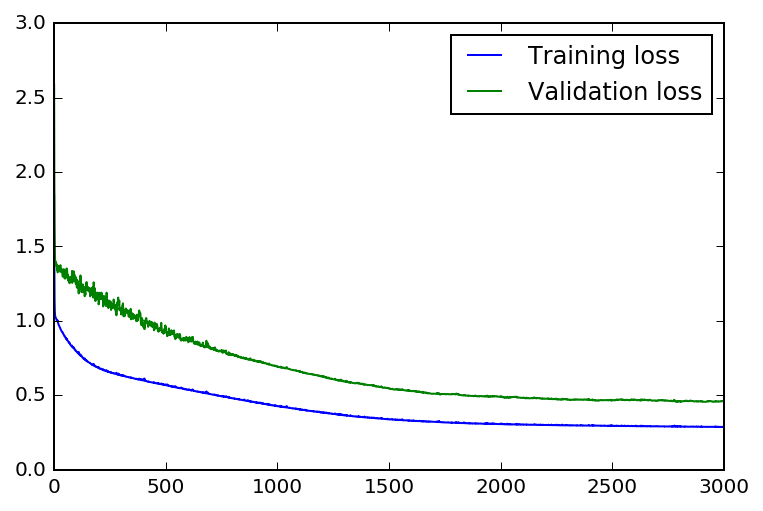

In [49]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## 检查预测结果

使用测试数据看看网络对数据建模的效果如何。如果完全错了，请确保网络中的每步都正确实现。

[ 0.02160921 -0.2688431  -0.66094913 -0.52559752 -0.55879709 -0.93459761
 -0.68522646 -0.8832316  -0.28332948  0.44418135  1.1591813   0.36165604
  0.12827715  0.21098893  0.39966696  0.45483002  0.34911005  0.3895461
  0.71072678  1.51674899  1.36504269  0.80604577  0.42154152  0.15693356
 -0.08670574 -0.27873642 -0.40028548 -0.55855733 -0.54954802 -0.61500749
 -0.57488032 -0.56245829 -0.28778924  0.40493798  1.06658727  0.32938178
  0.06361319  0.23510839  0.52001725  0.47718341  0.36081021  0.39080839
  0.70548854  1.47390224  1.35514262  0.74851149  0.40868811  0.11050933
 -0.08440084 -0.33826542 -0.49877542 -0.60842824 -0.65938322 -0.69776098
 -0.68102507 -0.61466223 -0.27200799  0.38620165  1.07548466  0.35611531
  0.15075353  0.28978294  0.55520449  0.54996901  0.45512019  0.4914291
  0.75829698  1.60222264  1.43315495  0.82775804  0.45954756  0.14943714
 -0.13557325 -0.33208487 -0.45561205 -0.56081123 -0.5542571  -0.63673267
 -0.63599793 -0.57195015 -0.30681698  0.36375651  1.0

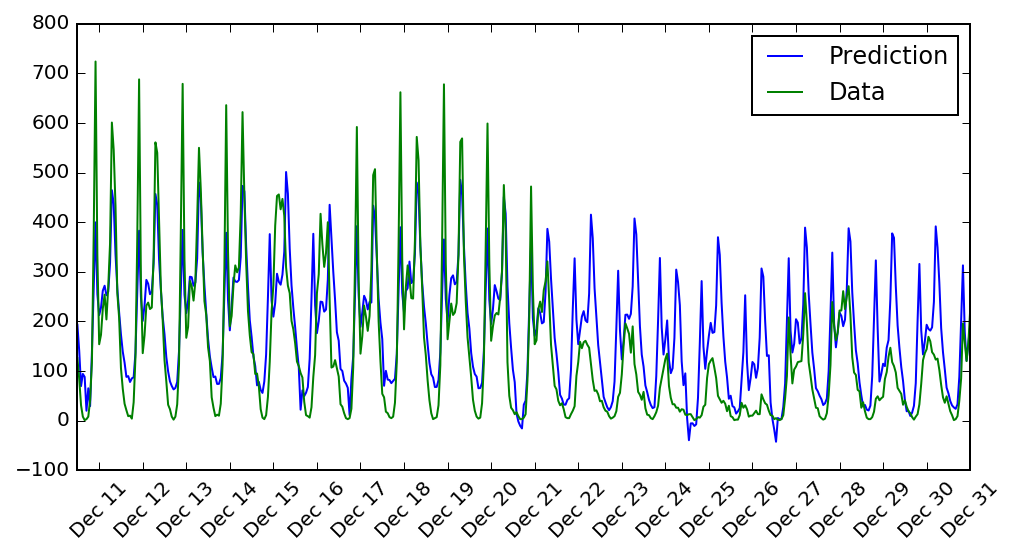

In [48]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
print(network.run(test_features).T[0])
print("=======================================")
print(test_targets['cnt'].values)
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## 可选：思考下你的结果（我们不会评估这道题的答案）

 
请针对你的结果回答以下问题。模型对数据的预测效果如何？哪里出现问题了？为何出现问题呢？

> **注意**：你可以通过双击该单元编辑文本。如果想要预览文本，请按 Control + Enter

#### 请将你的答案填写在下方
模型基本正确预测了数据变化的规律，但是在面对震荡幅度较小或较大的数据时候，并没有正确的匹配变化幅度，比如图中12月21日到12月30日。观察在数据处理阶段，data舍弃了工作日，假日等比较重要的输入，这可能是模型预测和真实数据差异的产生原因